<a href="https://colab.research.google.com/github/amalvarezme/AnaliticaDatos/blob/master/6_NN_DeepLearning/TransferLearning_autodiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Elaborado por Nicolás Pavón npavong@unal.edu.co y Andrés Álvarez amalvarezme@unal.edu.co .

# Transfer Learning (Transferencia de aprendizaje)

- $\textbf{Transfer Learning}$, nos permite el entramineto de redes neuronales profundas con la ventaja de usar menos datos para la tarea que queremos realizar.

- Por lo tanto estamos $\textbf{trasnfiriendo}$ el $\textbf{"Conocimiento"}$ aprendido por el modelo en anteriores tareas (utilizando bases de datos grandes) a nuestro modelo nuevo (depurado sobre bases de datos más pequeñas).

- La idea general del transfer learning consta en aprovechar los modelos y sus parámetros entrenados, tomarlos para resolver nuestras propias tareas


# Clasificación de imagenes con Redes Neuronales Convolucionales (CNN's)

- Como tarea vamos a realizar la clasificación de imagenes mediante CNN's utilizando las librerias de Tensorflow y Keras.

- Nuestro dataset [Cifar10] (https://www.cs.toronto.edu/~kriz/cifar.html) lo importaremos de Keras.datasets

- El conjunto de datos CIFAR-10 consta de 60.000 fotos divididas en 10 clases. Las clases incluyen objetos comunes como aviones, automóviles, aves, gatos, etc. en. El conjunto de datos se divide de forma estándar, donde se utilizan 50.000 imágenes para la formación de un modelo y los 10.000 restantes para evaluar su desempeño. Las imágenes están en RGB de 32 x 32 píxeles.

Tengamos a la mano funciones que nos ayuden a graficar tanto en escala RGB como en escala de grises.

In [0]:
def plot_image(img):
  plt.imshow(img, cmap="gray", interpolation="nearest")
  plt.axis("off")

def plot_color_image(img):
  plt.imshow(img, interpolation="nearest")
  plt.axis("off")

def crop(images):
  return images[150:220, 130:250]

1. Importemos las librerias TensorFlow y Keras

In [0]:
## instalamos los paquetes de tensorflow y keras
#!pip install tensorflow
#!pip install Keras
# Google colab, ya cuenta con la version más reciente de Tensorflow y Keras

In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [0]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

2. El conjunto de datos $\textbf{Cifar10}$ lo importaremos de Keras.

    - El conjunto de datos CIFAR-10 consta de 60.000 fotos divididas en 10 clases. Las clases incluyen objetos comunes como aviones, automóviles, aves, gatos, etc. en. El conjunto de datos se divide de forma estándar, donde se utilizan 50.000 imágenes para la formación de un modelo y los 10.000 restantes para evaluar su desempeño. Las imágenes están en los 3 canales (rojo, verde y azul) y son cuadrados pequeños que miden 32 x 32 píxeles.

    - El dataset cifar10 ya se encuentra divido en los conjuntos de train y test

In [5]:

X_data = keras.datasets.cifar10

(X_train_full, y_train_full),(X_test, y_test) = X_data.load_data()

170500096/170498071 [==============================] - 13s 0us/step


In [6]:
X_train_full.shape

(50000, 32, 32, 3)

In [7]:
X_train_full.dtype

dtype('uint8')

- Se puede ver que el conjunto de entrenamineto contiene 50.000 imágenes en los 3 canales, cada imagen de 32x32 píxeles

- Vamos a escalar la intesidad de los píxeles para tenerlas en un rango de 0-1, además de convertirlas en flotantes. Es de buena práctica trabajar con datos normalizados.

In [0]:
X_valid, X_train = (X_train_full[:4000])/255.0 , (X_train_full[4000:])/255.0
X_test = X_test/255
y_valid, y_train = y_train_full[:4000], y_train_full[4000:]

In [9]:
X_valid.shape

(4000, 32, 32, 3)

In [10]:
X_test.shape

(10000, 32, 32, 3)

Podemos visuzalizar las imagenes dentro del conjunto usando la funcion imshow() del paquete Matplotlib

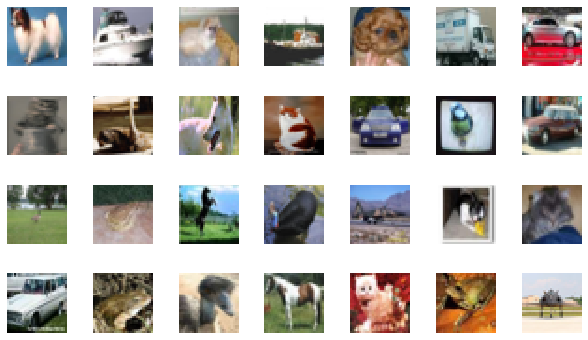

In [11]:
rows = 4
cols = 7
plt.figure(figsize=(cols * 1.5, rows * 1.5))
for row in range(rows):
  for col in range(cols):
    index = cols * row + col
    plt.subplot(rows, cols, index + 1)
    plt.imshow(X_train[index], interpolation="nearest")
    plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## 3. Arquitectura CNN

## Trasnfer learning con modelo pre-entrenado para la extracción de característcias.

- Para este otro ejercicio vamos a aplicar algo del *trasnfer Learning*:
  - Vamos a usar el modelo en keras **ResNet50**

  - Para implementar *transfer learning*, vamos a remover la última capa de predicción del model ResNet(podemos ver en la figura) y la remplazamos con nuestras propias capas.

  - Los pesos del modelo pre-entrenado se utilizan para la extracción de caraterísticas.

  - Los pesos del modelo pre-entrenado quedan 'congelados' y no se actualizan durante el entrenamiento 

In [12]:
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout #con el paquete tf.keras molesta con los shapes

model_pre = ResNet50(include_top=False, weights='imagenet', input_shape=(32,32,3))
#model_pre = VGG16(include_top=False, input_shape=(300, 300, 3))
for layer in model_pre.layers:
    layer.trainable = False

#secuencial    
'''
model = Sequential([
    model_pre,
    Dense(units=512, activation='relu', input_dim=[32,32,3]),
    Dropout(0.3),
    Dense(units=512, activation='relu'),
    Dropout(0.3),
    Dense(units=10, activation='softmax')
])
'''
#funcional
#flat1 = Flatten()(model_pre.layers[-1])
h1 = Dense(512, activation='relu')(model_pre.output)
d1 = Dropout(0.3)(h1)
h2 = Dense(512, activation='relu')(d1)
d2 = Dropout(0.3)(h2)
output = Dense(10, activation='softmax')(d2)
output = Flatten()(output)
# define new model
model = Model(inputs=model_pre.inputs, outputs=output)

# summarize

model.summary()
#tf.keras.utils.plot_model(model,show_shapes=True)



Using TensorFlow backend.


94658560/94653016 [==============================] - 8s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________

- Los pesos los vamos a dejar tal cual vienen del modelo, por eso tenemos que: **layer.trainable = False** porque no queremos entrenar el modelo, lo que buscamos es aprovechar el "conocimiento" y adaptarlo a nuestro modelo.

,Analicemos cada línea de código del modelo:

- Hemos creado nuestor modelo usando transfer learning con ayuda del modelo pre-entrenado ResNet50, que si vemos ya tiene incluidas las capas de *flatten()*,*(Conv2D)* y las que hubieramos añadido a nuestro nuevo modelo.


- Luego está la red totalmente conectada (Fully-connected), compuesta de 1 capa densa oculta y una capa de salida densa. Tenga en cuenta que **debemos aplanar sus entradas**, ya que una red densa espera una matriz 1D de características para cada instancia. También agregamos dos capas de *dropout*, con una tasa de dropout del $30\%$ 

#### 4. Compilamos y ajustamos el modelo.


In [0]:
 model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [0]:
#keras.utils.plot_model(model, "my_ciffar_model.png", show_shapes=True)
#model.summary()

In [14]:
model.input_shape
X_train.shape
X_valid.shape
#y_train.shape
zz = model_pre.predict(X_train[:30])
zz.shape
model_pre.outputs

[<tf.Tensor 'activation_49/Relu:0' shape=(None, 1, 1, 2048) dtype=float32>]

In [0]:
#epochs = 25
hist = model.fit(X_train, y_train, epochs=20,
                 validation_data=(X_valid, y_valid), batch_size=32)

Train on 46000 samples, validate on 4000 samples
Epoch 1/20
46000/46000 [==============================] - 24s 523us/step - loss: 1.9228 - accuracy: 0.3267 - val_loss: 3.1730 - val_accuracy: 0.1050
Epoch 2/20
46000/46000 [==============================] - 21s 465us/step - loss: 1.6520 - accuracy: 0.4152 - val_loss: 4.3504 - val_accuracy: 0.1050
Epoch 3/20
46000/46000 [==============================] - 22s 468us/step - loss: 1.5744 - accuracy: 0.4452 - val_loss: 5.0588 - val_accuracy: 0.1050
Epoch 4/20
46000/46000 [==============================] - 22s 468us/step - loss: 1.5312 - accuracy: 0.4587 - val_loss: 5.4508 - val_accuracy: 0.1050
Epoch 5/20
46000/46000 [==============================] - 22s 476us/step - loss: 1.5017 - accuracy: 0.4715 - val_loss: 5.5733 - val_accuracy: 0.0993
Epoch 6/20
46000/46000 [==============================] - 21s 457us/step - loss: 1.4746 - accuracy: 0.4791 - val_loss: 6.0839 - val_accuracy: 0.0995
Epoch 7/20
46000/46000 [==============================] -

- Se eligió un pequeño número de épocas resolver esta tarea de forma rápida. Normalmente, el número de épocas sería entre dos o tres veces el valor escogido para resolver este tipo de tareas. 

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (score[1]*100))

Accuracy: 9.99%


5. Por último hacemos nuestra predicción, en este caso vamos a pretender que tenemos una nuevas imagenes que tomaremos del conjunto X_test

In [0]:
X_new = X_test[:10] # New images
y_pred = model.predict(X_new)

In [0]:
y_pred

array([[1.5915293e-01, 1.7508099e-05, 7.9494286e-01, 3.2379254e-04,
        4.0669944e-02, 4.4673079e-04, 3.0202423e-03, 5.3001114e-04,
        8.9266867e-04, 3.3314943e-06],
       [1.4633155e-01, 1.6784265e-05, 8.0622202e-01, 3.0399335e-04,
        4.2049129e-02, 4.3607684e-04, 3.2882926e-03, 5.9300289e-04,
        7.5607136e-04, 3.0786739e-06],
       [1.3950087e-01, 1.8429171e-05, 8.1150019e-01, 3.4596259e-04,
        4.3487635e-02, 4.9377518e-04, 3.2541568e-03, 6.6232012e-04,
        7.3310622e-04, 3.4326995e-06],
       [1.7698775e-01, 1.2241520e-05, 7.8148025e-01, 2.4356817e-04,
        3.7415728e-02, 3.6083243e-04, 2.1561675e-03, 4.3684489e-04,
        9.0405636e-04, 2.6374050e-06],
       [1.3482146e-01, 1.5790480e-05, 8.1958115e-01, 3.0796436e-04,
        4.0189065e-02, 4.1625099e-04, 3.4772023e-03, 5.8531499e-04,
        6.0312508e-04, 2.7107801e-06],
       [1.3734195e-01, 2.0257434e-05, 8.1477708e-01, 3.5788119e-04,
        4.1580912e-02, 4.7910467e-04, 4.0383558e-03, 6.56

- Guardemos el modelo, para hacer transfer learning, por si en el futuo necesitamos hacer otro clasificador.

In [0]:
model.save("my_model.h5py")

Otros formatos para guardar y cargar modelos de keras:

[save_load model keras](https://machinelearningmastery.com/save-load-keras-deep-learning-models/)

# Otras aplicaciones de transfer learning y visión con redes neuronales


[Semantic Segmentation](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47)

# Autodiff en keras

La clave de la eficiencia en redes con deep learning es el autodiff

[Autodiff](https://en.wikipedia.org/wiki/Automatic_differentiation)

In [0]:
#ejemplo simple de autodiff
#funcion a derivar
def f(w1,w2):
  return 3*w1**2 + 2 *w1*w2

  

In [19]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1+eps,w2)-f(w1,w2))/eps #estimacion numerica de la derivada

36.000003007075065

In [0]:
(f(w1,w2+eps)-f(w1,w2))/eps #

La aproximación numérica funciona bien pero debe llamarse $f(\cdot)$ para calcular el gradiente de cada variable, intratable para muchos parámetros en deep learning.

El gradient tape de tensorflow (autodiff) facilita los cálculos del gradiente y lo hace eficiente para grandes cantidades de parámetros

In [21]:
w1,w2 = tf.Variable(5.),tf.Variable(3.)
with tf.GradientTape() as tape: #crear contexto gradient tape para guardar cada operacion que envuelve una variable
  z=f(w1,w2) #funcion de perdida (loss) para salvar memoria colocar la menor cantidad de codigo en el tape

gradients = tape.gradient(z,[w1,w2]) # tape calcula  los gradientes del resultado z con respecto a [w1,w2]
gradients #gradient tape hace los calculos una sola vez de forma inversa sin importar la cantidad de variables

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

## Cuando se hace fit a un modelo secuencial o funcional en keras, utiliza gradient tape.

## Si se desea se pueden utilizar los gradientes de gradientTape y un paso personalizado fuera del ambiente model.fit() para problemas especializados sin necesidad de hacer el cálculo analítico de gradientes

## Para proyectos especializados ver:

[Custom training loop tf](https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough)